In [1]:
import json
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from utils import load_data

%matplotlib inline

# increase width of the notebook display in browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

# Load Data

## Training

In [3]:
data_path = Path('.') / 'data' / 'satire'
training_dict = load_data(data_path / 'training', data_path / 'training-class')
training = pd.DataFrame(training_dict)
print('Loaded %d samples for training' % training.shape[0])
training.head()

ERROR:root:Could not find label for file #training-2036#


Loaded 2638 samples for training


,id,label,text
0,training-1516,1,Unemployment Rate in New Zealand Keeps Rising ...
1,training-2393,1,Four Hospitalized with Radiation Sickness \n\n...
2,training-1724,0,Cheney Wins Marathon\n\n Riding on the backs...
3,training-1340,1,Argentina Fails to Respect Tradition: Maradona...
4,training-0292,1,-- After making historic gains in Congress two...


In [4]:
print(training.iloc[0].text)

Unemployment Rate in New Zealand Keeps Rising 

   The unemployment rate in New Zealand rose from 7.7 percent in June to
   8.1 percent in September and is expected to peak at 8.8 percent in the
   middle of next year, the Evening Post reported Monday.

   The Wellington-based newspaper quoted a local economist as saying that
   a weak domestic economy, troubled offshore markets and tariff cuts are
   the main reasons for the lengthening jobless queue.

   According to the figures for June released by New Zealand's Household
   Labor Force Survey, 140,600 New Zealanders were out of work,
   WestpacTrust economist Paul Gardiner said. Data from the latest survey
   for September, due to be released on Thursday, will show unemployment
   has risen above eight percent to 147,600, he added.

   "Such a result will see the unemployment rate rise from 7.7 percent in
   June to 8.1 percent in September, the highest level since the 1991
   recession," Gardiner said.

   He said that the labor m

## Test

In [5]:
test_dict = load_data(data_path / 'test', data_path / 'test-class')
test = pd.DataFrame(test_dict)
print('Loaded %d samples for testing' % test.shape[0])
test.head()

Loaded 1595 samples for testing


,id,label,text
0,test-0569,1,"Diplomatic News Summary (2) Chinese, Japanese ..."
1,test-0931,1,Israeli Warplanes Attack Palestinian Police He...
2,test-1219,1,Nokia loses 200 million dollar US order as cli...
3,test-0132,1,Following are the domestic news items released...
4,test-0300,1,Zimbabwe Drafts Bill to Penalize Polluters \n\...


# Describe Data
1 - true news wire

0 - satire

Support for all classes
--------------------------------------------------
[(1, 4000), (0, 233)]


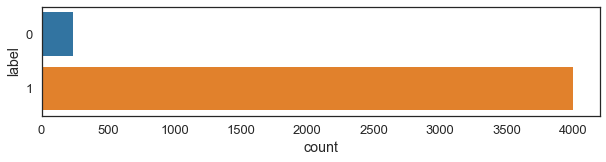

In [6]:
data = training.append(test)

print('Support for all classes\n' + '-' * 50)
print(Counter(data.label).most_common())

sns.set_context("talk")
sns.set_style("white")
plt.figure(figsize=(10, 2))
sns.countplot(y=data.label, orient="v")

# Experiments
Try varying the feature weighting and classification algorithm.

Feature Weighting:
- Binary Weights
- Count Weights
- TFIDF Weights

Classification Algorithms:
- Multinomial Naive Bayes
- Cross-Validated Logistic Regression
- Linear Support Vector Machine

Additinally, I tried oversampling (random as well as using SMOTE). 
To this end, the data was preprocessed with PCA to deal with data sparseness.
- PCA + Random Oversampling
- PCA + SMOTE

## Evaluation Utilities

In [7]:
from sklearn.metrics import *
from functools import partial

my_precision_score = partial(precision_score, pos_label=0)
my_recall_score = partial(recall_score, pos_label=0)
my_f1_score = partial(f1_score, pos_label=0)
METRICS = [roc_auc_score, accuracy_score, matthews_corrcoef, my_precision_score, my_recall_score, my_f1_score]
METRIC_NAMES = ['ROC', 'Accuracy', 'Matthews Corr. Coeff', 'Precision', 'Recall', 'F1']

def fit_predict_report(pipe, file=None):
    clf = pipe()
    clf.fit(training.text, training.label)
    predicted = clf.predict(test.text)
    
    results = {'pipe': pipe.__name__}
    for i, metric in enumerate(METRICS):
        results[METRIC_NAMES[i]] = metric(test.label, predicted)
    return results

## Define Pipelines

In [8]:
def get_binary_weight_multinomial_nb():
    return make_pipeline(CountVectorizer(binary=True),
                         MultinomialNB())

def get_binary_weight_logistic_regression_cv():
    return make_pipeline(CountVectorizer(binary=True),
                         LogisticRegressionCV())
    
def get_binary_weight_linear_svc():
    return make_pipeline(CountVectorizer(binary=True),
                         SVC(kernel='linear'))
    
def get_count_weight_multinomial_nb():
    return make_pipeline(CountVectorizer(),
                         MultinomialNB())

def get_count_weight_logistic_regression_cv():
    return make_pipeline(CountVectorizer(),
                         LogisticRegressionCV())

def get_count_weight_linear_svc(**kwargs):
    return make_pipeline(CountVectorizer(),
                         SVC(kernel='linear', **kwargs))    

def get_tfidf_weight_multinomial_nb():
    return make_pipeline(TfidfVectorizer(min_df=3, stop_words='english',
                                         ngram_range=(1, 2), lowercase=True,
                                         max_features=10000),
                         MultinomialNB())

def get_tfidf_weight_logistic_regression_cv():
    return make_pipeline(TfidfVectorizer(min_df=3, stop_words='english',
                                         ngram_range=(1, 2), lowercase=True,
                                         max_features=10000),
                         LogisticRegressionCV())

def get_tfidf_weight_linear_svc():
    return make_pipeline(TfidfVectorizer(min_df=3, stop_words='english',
                                         ngram_range=(1, 2), lowercase=True,
                                         max_features=10000),
                         SVC(kernel='linear'))

def get_count_weight_pca_smote_linear_svm():
    return imb_make_pipeline(CountVectorizer(),
                             TruncatedSVD(n_components=500),
                             SMOTE(k_neighbors=3),
                             SVC(kernel='linear'))

def get_count_weight_pca_oversampling_linear_svm():
    return imb_make_pipeline(CountVectorizer(),
                             TruncatedSVD(n_components=500),
                             RandomOverSampler(),
                             SVC(kernel='linear'))

## Gather Experiment Results

In [9]:
PIPES = [
    get_binary_weight_multinomial_nb,
    get_binary_weight_logistic_regression_cv,
    get_binary_weight_linear_svc,
    get_count_weight_multinomial_nb,
    get_count_weight_logistic_regression_cv,
    get_count_weight_linear_svc,
    get_tfidf_weight_multinomial_nb,
    get_tfidf_weight_logistic_regression_cv,
    get_tfidf_weight_linear_svc,
    get_count_weight_pca_smote_linear_svm,
    get_count_weight_pca_oversampling_linear_svm
]

results = []
for pipe in PIPES:
    results.append(fit_predict_report(pipe))
    
with open('results.json', 'w') as outfile:
    json.dump(results, outfile, indent=4)

/Users/mlehl/anaconda/envs/satire_detector/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/mlehl/anaconda/envs/satire_detector/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mlehl/anaconda/envs/satire_detector/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
pd.read_json('results.json', orient='records')

,Accuracy,F1,Matthews Corr. Coeff,Precision,ROC,Recall,pipe
0,0.937304,0.090909,0.143288,0.500000,0.523328,0.05,get_binary_weight_multinomial_nb
1,0.963636,0.658824,0.651630,0.800000,0.775318,0.56,get_binary_weight_logistic_regression_cv
2,0.962382,0.655172,0.643818,0.770270,0.779314,0.57,get_binary_weight_linear_svc
3,0.952978,0.436090,0.489323,0.878788,0.643662,0.29,get_count_weight_multinomial_nb
4,0.964263,0.662722,0.656917,0.811594,0.775652,0.56,get_count_weight_logistic_regression_cv
5,0.966144,0.689655,0.680706,0.810811,0.795318,0.60,get_count_weight_linear_svc
6,0.937304,0.000000,0.000000,0.000000,0.500000,0.00,get_tfidf_weight_multinomial_nb
7,0.957994,0.496241,0.562001,1.000000,0.665000,0.33,get_tfidf_weight_logistic_regression_cv
8,0.951097,0.360656,0.457265,1.000000,0.610000,0.22,get_tfidf_weight_linear_svc
9,0.961755,0.680628,0.661167,0.714286,0.816304,0.65,get_count_weight_pca_smote_linear_svm


# Best Model: Count Weighting + Linear SVC

## Classification Report

In [11]:
best_pipe = get_count_weight_linear_svc()
best_pipe.fit(training.text, training.label)
test['predicted'] = best_pipe.predict(test.text)
print(classification_report(test.label, test.predicted))

             precision    recall  f1-score   support

          0       0.81      0.60      0.69       100
          1       0.97      0.99      0.98      1495

avg / total       0.96      0.97      0.96      1595



## Confusion Matrix

[[  60   40]
 [  14 1481]]


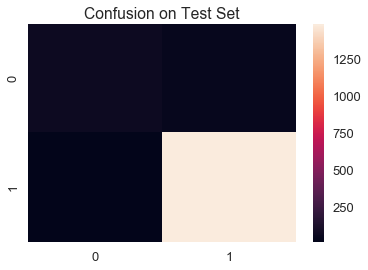

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(test.label, test.predicted)
print(confusion)
heatmap = sns.heatmap(confusion)
heatmap.set_title('Confusion on Test Set')
heatmap

## Best Predictors

In [13]:
import eli5

clf = best_pipe.steps[-1][1]
vec = best_pipe.steps[0][1]
eli5.show_weights(clf, vec=vec, top=50)

/Users/mlehl/anaconda/envs/satire_detector/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Explain Prediction

In [14]:
import eli5
from eli5.lime import TextExplainer

best_pipe = get_count_weight_linear_svc(probability=True)
best_pipe.fit(training.text, training.label)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [15]:
te = TextExplainer(random_state=42)
te.fit(test[test.label == 0].iloc[2].text, best_pipe.predict_proba)
te.show_prediction()

# View Errors

## True Negatives
(it IS satire and we predict satire)

In [16]:
tns = test[(test.label == 0) & (test.predicted == 0)]
for i, tn in tns.iterrows():
    print(tn.text[:300])
    print('-' * 50)

Roger Federer refuses to play tennis until named most handsome man on tour

   The controversy over who is the best looking male tennis player in the
   world heated up to a new level today. In a hastily convened press
   conference Roger Federer announced that he was effectively going on
   strike 
--------------------------------------------------
Also hockey moms are usually less rabid than pit bulls

   By Sarah Palin

   Golly! Wasn't that something last night? Before this, the biggest crowd
   I ever spoke to was a crowd of 94 on Inuit Awareness Day (43 if you
   subtract huskies).

   Did you like that barb about how being mayor of Wasil
--------------------------------------------------
George Bush bites off Vladimir Putin's head at WTO summit

   As the news conference concluded between the cheerful leaders of the free
   world, a smiling President George W. Bush left his podium and approached
   Russian leader Vladimir Putin with extended arms, patted his back, turned
   to t

## False Negatives
(it IS satire, but we predict news wire)

In [17]:
tns = test[(test.label == 0) & (test.predicted == 1)]
for i, tn in tns.iterrows():
    print(tn.text[:300])
    print('-' * 50)

Bank of England Denies Rewarding Reckless Lenders

   Governor of the Bank of England, Mervyn King, today denied that its
   recent initiative to free up the financial markets amounted to a bail
   out of the very institutions responsible for creating the problems.
   The arrangement involves swappi
--------------------------------------------------
Eliot Spitzer hooker agency nets Brazilian footballer Ronaldo

   NYPD investigators are cock-a-hoop after a sting op in the Eliot Spitzer
   hooker agency probe netted Brazilian footballer and AC/DC Milan star
   striker Ronaldo.

   The 31 year-old international had been partying in the Lonesome C
--------------------------------------------------
Obama's aircraft makes emergency landing after Hillary discovered at controls!

   Presidential candidate Barack Hussein Obama had to make an emergency
   landing on his way to a campaign stop in North Carolina.  The Boeing 737
   campaign chartered JetBreeze aircraft was acting 'strangely' acco

## False Positives
(it IS news wire, but we predict satire)

In [18]:
tns = test[(test.label == 1) & (test.predicted == 0)]
for i, tn in tns.iterrows():
    print(tn.text[:300])
    print('-' * 50)

Paralyzed Chinese Gymnast Shows Great Courage

   She is smiling and consoling her weeping mother, even though she cannot
   feel anything from mid-chest down.

   The braveness and courage shown by the 17-year-old Chinese female
   gymnast Sang Lan moved everyone who went to see her after Tuesday's
--------------------------------------------------
As a public service to those thoroughly confused NFL fans who are
   trying to decipher the playoff picture, please find enclosed the
   official league tiebreakers. As always, any rebroadcast or
   retransmission of this ``Weekend Picks'' exclusive is against all sorts
   of rules and stuff, unless
--------------------------------------------------
AN ANGRY MAN FOUND HIMSELF IN `TOM JONES' (BC-RICHARDSON-FILMS-$ADV21-NYT)

   In Tony Richardson's engagingly chatty memoir, ``The Long-Distance
   Runner,'' the English film director who died three years ago expresses
   surprisingly negative feelings about ``Tom Jones,'' the movie that many
 